<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/RNN%20and%20RC%20ECG%20timeseries%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import lstsq # For least squares solution

# Import additional libraries for RNN
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

Loading ECG data...
    time  ecg_value
0  0.000        496
1  0.001        496
2  0.002        497
3  0.003        498
4  0.004        498
Total data points: 17935
Calculated time step (dt): 0.001000s (Implies Fs = 1000.00 Hz)
Assumed Sampling Rate: 1000 Hz
Test Points (last 5.0s): 5000
Training points: 12935 (12.93s)
Testing points: 5000 (5.00s)

Preparing training data: input window 50, output window 10...
Training input sequences shape: (12876, 50)
Training output sequences shape: (12876, 10)

Initializing and training RC...
Solving for output weights...
Trained W_out shape: (1000, 10)
RC training complete.

Initializing and training RNN...
Epoch [10/20], Loss: 859.060720
Epoch [20/20], Loss: 860.679670
RNN training complete.

Generating non-autonomous predictions for test signal (with warm-up)...
Warming up reservoir for 50 steps...
Warm-up complete. Reservoir state initialized.
RC predicted signal length: 5000
RNN predicted signal length: 5000
Test signal length: 5000

--- Reserv

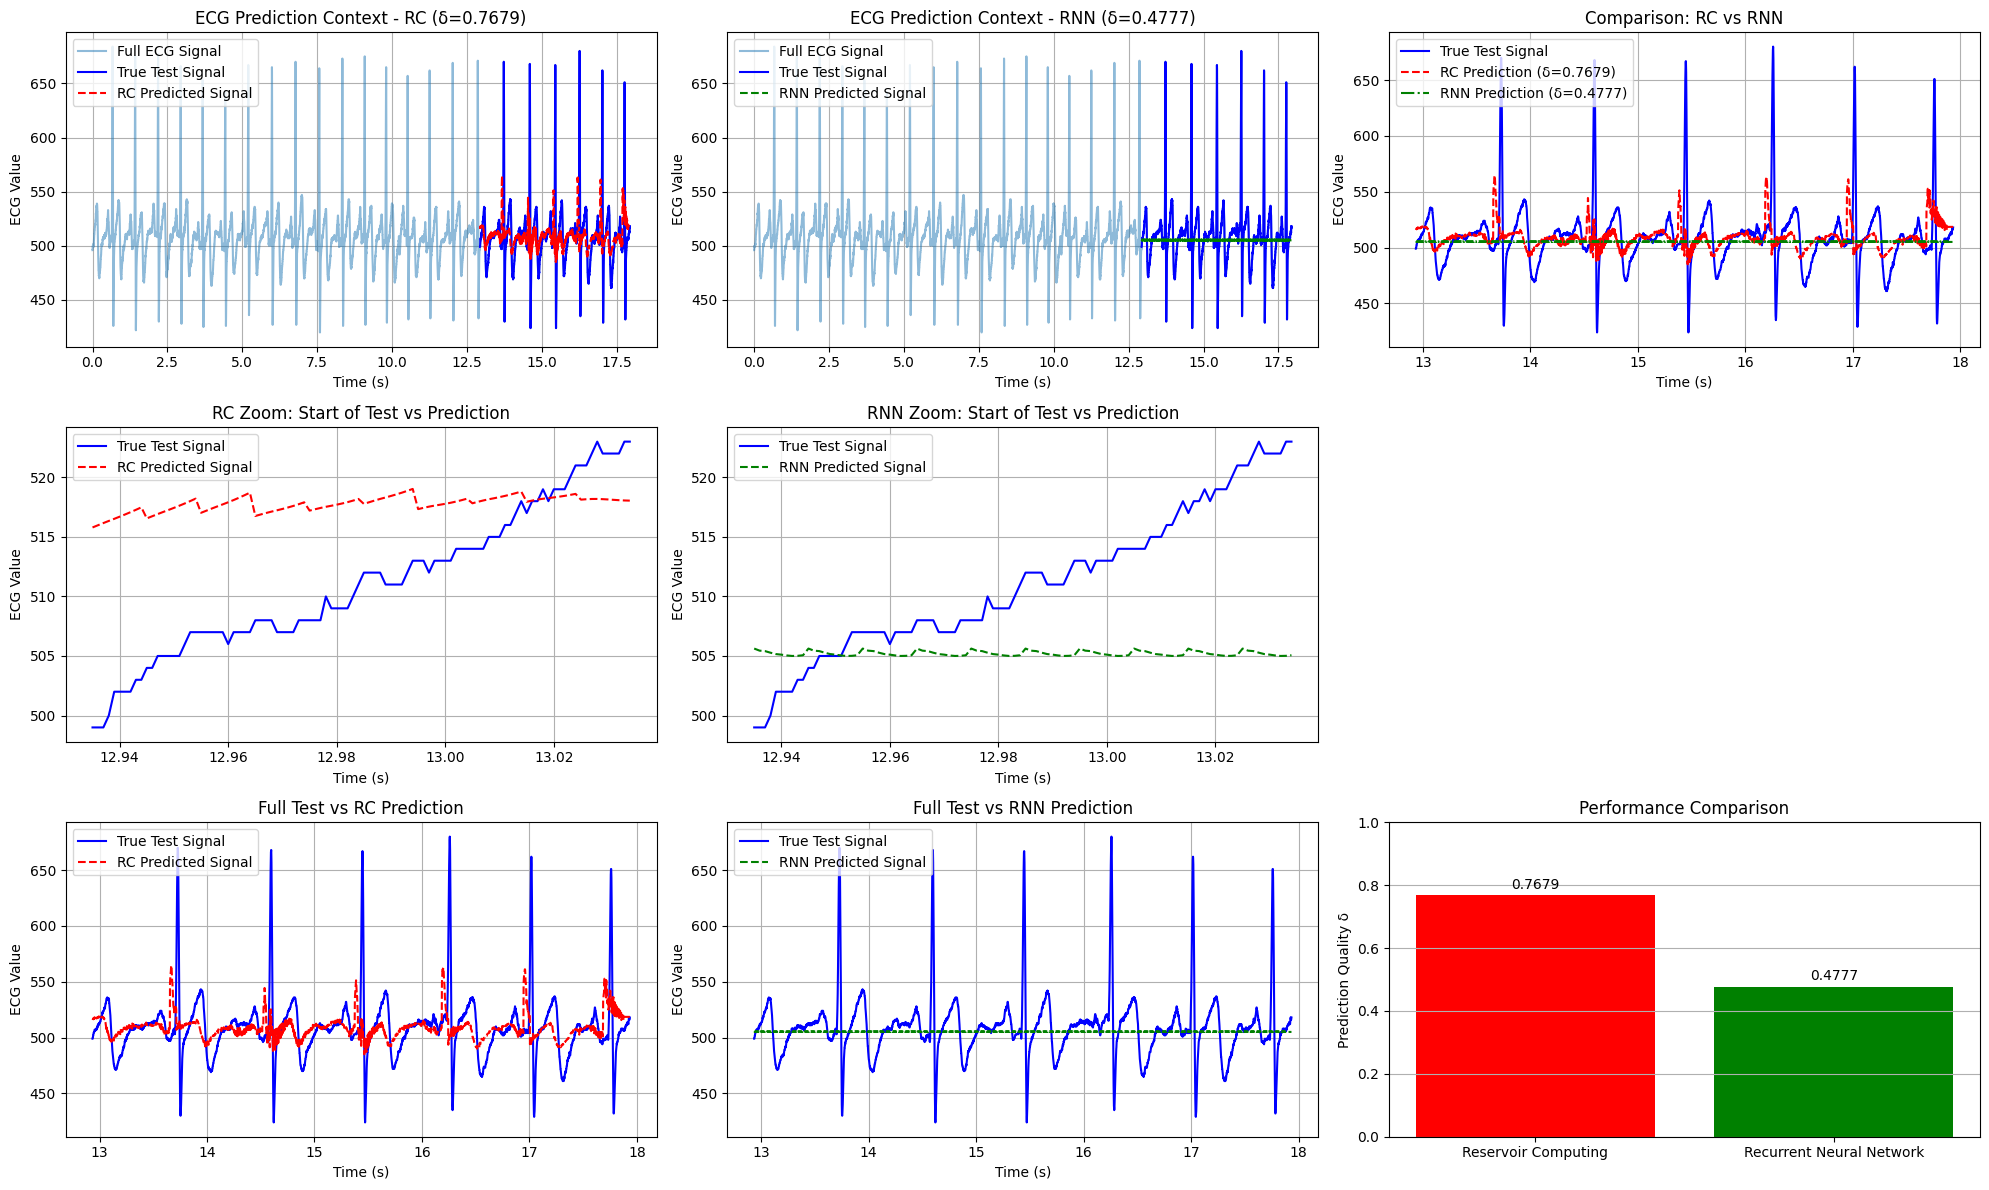

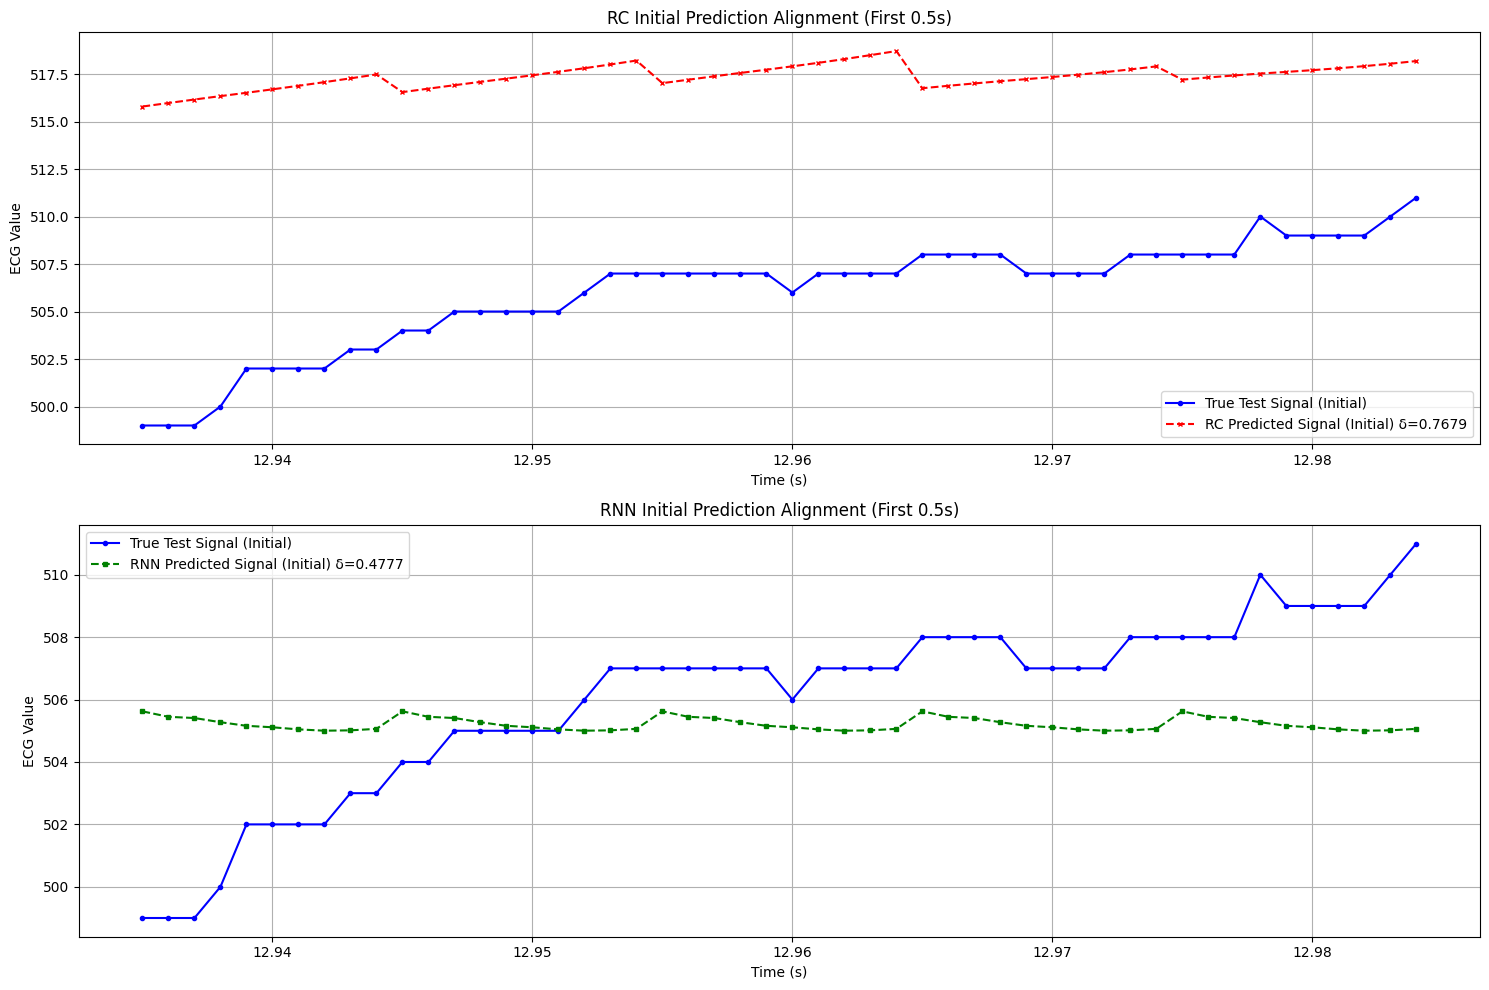


DETAILED COMPARISON SUMMARY
Reservoir Computing:
  - Normalized RMSE: 0.232131
  - Prediction Quality δ: 0.767869
Recurrent Neural Network:
  - Normalized RMSE: 0.522286
  - Prediction Quality δ: 0.477714

Winner: RC
Performance Difference: 0.290155


In [4]:


# --- 1. Load and Prepare ECG Data ---
print("Loading ECG data...")
df = pd.read_csv('ecg_1d_timeseries_prediction.csv', delimiter=';')
print(df.head())
print(f"Total data points: {len(df)}")
dt_calculated = df['time'].diff().mean()
print(f"Calculated time step (dt): {dt_calculated:.6f}s (Implies Fs = {1/dt_calculated:.2f} Hz)")

time_full = df['time'].values
ecg_full = df['ecg_value'].values

# Define split: last 5 seconds for testing
test_duration_sec = 5.0
sampling_rate = int(np.round(1.0 / dt_calculated))
test_points = int(test_duration_sec * sampling_rate)

print(f"Assumed Sampling Rate: {sampling_rate} Hz")
print(f"Test Points (last {test_duration_sec}s): {test_points}")

time_train = time_full[:-test_points]
ecg_train = ecg_full[:-test_points]
time_test = time_full[-test_points:]
ecg_test_true = ecg_full[-test_points:]

print(f"Training points: {len(ecg_train)} ({time_train[-1] - time_train[0]:.2f}s)")
print(f"Testing points: {len(ecg_test_true)} ({time_test[-1] - time_test[0]:.2f}s)")

# --- 2. Define the Reservoir Computing Model ---
class RC_ECG_Predictor:
    def __init__(self, n_reservoir=800, spectral_radius=0.9, input_scaling=0.5,
                 leak_rate=0.3, regularization=1e-8, seed=42):
        """
        RC model for ECG prediction using windowed input/output.
        Predicts a future window based on a past window.
        """
        self.n_reservoir = n_reservoir
        self.spectral_radius = spectral_radius
        self.input_scaling = input_scaling
        self.leak_rate = leak_rate
        self.regularization = regularization
        self.seed = seed
        self.W_in = None
        self.W_res = None
        self.W_out = None
        self.state = None

    def _initialize_weights(self, input_dim):
        """Initialize reservoir weights."""
        np.random.seed(self.seed)
        self.W_in = (np.random.rand(self.n_reservoir, input_dim) - 0.5) * 2 * self.input_scaling
        connectivity = 0.1
        self.W_res = np.random.rand(self.n_reservoir, self.n_reservoir) - 0.5
        self.W_res[np.random.rand(self.n_reservoir, self.n_reservoir) > connectivity] = 0
        eigenvalues = np.linalg.eigvals(self.W_res)
        max_eigval_magnitude = np.max(np.abs(eigenvalues))
        if max_eigval_magnitude > 0:
            self.W_res = self.W_res * (self.spectral_radius / max_eigval_magnitude)

    def _update_state(self, input_vec):
        """Update the reservoir state."""
        if self.state is None:
            self.state = np.zeros(self.n_reservoir)
        if input_vec.ndim > 1:
            input_vec = input_vec.flatten()
        new_state = np.tanh(np.dot(self.W_in, input_vec) + np.dot(self.W_res, self.state))
        self.state = (1 - self.leak_rate) * self.state + self.leak_rate * new_state

    def train(self, input_sequences, output_sequences):
        """
        Train the RC.
        Args:
            input_sequences: 2D array (n_samples, input_window_size)
            output_sequences: 2D array (n_samples, output_window_size)
        """
        input_sequences = np.atleast_2d(input_sequences)
        output_sequences = np.atleast_2d(output_sequences)

        if input_sequences.shape[0] != output_sequences.shape[0]:
            raise ValueError(f"Mismatched samples: inputs {input_sequences.shape[0]}, outputs {output_sequences.shape[0]}")

        input_dim = input_sequences.shape[1]
        self._initialize_weights(input_dim)

        n_samples = input_sequences.shape[0]
        R = np.zeros((n_samples, self.n_reservoir))

        self.state = np.zeros(self.n_reservoir)
        print(f"Collecting reservoir states for {n_samples} samples...")
        for i in range(n_samples):
            self._update_state(input_sequences[i])
            R[i, :] = self.state

        print("Solving for output weights...")
        self.W_out, _, _, _ = lstsq(R, output_sequences, cond=self.regularization)
        print(f"Trained W_out shape: {self.W_out.shape}")

    def predict(self, input_signal):
        """
        Predict output windows for a given input signal (non-autonomous).
        Args:
            input_signal: 1D array containing the signal to drive predictions.
        Returns:
            predicted_signal: 1D array of predicted values.
        """
        if self.W_out is None:
            raise ValueError("Model must be trained before prediction.")

        input_window_size = self.W_in.shape[1]
        output_window_size = self.W_out.shape[1]

        if len(input_signal) < input_window_size:
            raise ValueError("Input signal too short.")

        # --- Modified Prediction with Warm-up ---
        # 1. Warm-up the reservoir state
        # Drive the reservoir with the beginning of the input signal to initialize its state
        warmup_steps = input_window_size # Use one window size for warmup
        print(f"Warming up reservoir for {warmup_steps} steps...")
        self.state = np.zeros(self.n_reservoir) # Reset state before warmup
        for t in range(min(warmup_steps, len(input_signal) - input_window_size + 1)):
             warmup_input = input_signal[t : t + input_window_size]
             self._update_state(warmup_input)
        print("Warm-up complete. Reservoir state initialized.")

        # 2. Now perform predictions
        n_predictable_points = len(input_signal) - input_window_size + 1
        if n_predictable_points <= 0:
            return np.array([])

        predictions = []
        time_indices = []

        # Start prediction from where warmup left off (or from the beginning if no warmup offset is needed)
        # We continue from the point where we can make the first full prediction after warmup
        t_start = 0 # We have already warmed up, so we start predicting from t=0 using the warmed-up state
        predictions_made = 0
        # Number of initial predictions to discard for stabilization
        discard_initial_predictions = 1 # Discard the first prediction output

        while t_start <= len(input_signal) - input_window_size:
            input_win = input_signal[t_start : t_start + input_window_size]
            # Update reservoir state with this window (using the warmed-up state)
            self._update_state(input_win)

            # Predict the next output window
            pred_out_win = np.dot(self.W_out.T, self.state) # Shape (output_window_size,)

            # Only store predictions after discarding initial ones
            if predictions_made >= discard_initial_predictions:
                predictions.append(pred_out_win)
                # Store time index for the *start* of this predicted window
                time_indices.append(t_start + input_window_size)

            predictions_made += 1
            # Move window by the output window size
            t_start += output_window_size

        if not predictions:
            print("Warning: No predictions stored after warmup/discard.")
            return np.array([])

        # --- Reconstruct Full Predicted Signal ---
        try:
            ecg_predicted_full = np.concatenate(predictions)
        except ValueError as e:
            print(f"Error concatenating predictions: {e}")
            print("Prediction shapes:", [p.shape for p in predictions])
            # Fallback: try raveling if predictions are not 1D
            flattened_preds = [p.ravel() for p in predictions]
            ecg_predicted_full = np.concatenate(flattened_preds)

        return ecg_predicted_full

# --- 3. Define the Recurrent Neural Network Model ---
class RNN_ECG_Predictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, output_size=10, dropout=0.2):
        super(RNN_ECG_Predictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Use LSTM for better performance
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)

        # Fully connected layer to map hidden state to output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Take the last time step's output
        out = out[:, -1, :]

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out

# --- 4. Prepare Training Data (Windowed Input -> Windowed Output) ---
def create_io_sequence_pairs(data, input_window_size, output_window_size):
    """Creates input and output sequence pairs."""
    X, Y = [], []
    for i in range(len(data) - input_window_size - output_window_size + 1):
        X.append(data[i:i + input_window_size])
        Y.append(data[i + input_window_size : i + input_window_size + output_window_size])
    return np.array(X), np.array(Y)

# Hyperparameters
input_window_size = 50
output_window_size = 10
print(f"\nPreparing training data: input window {input_window_size}, output window {output_window_size}...")
inputs_train_seq, outputs_train_seq = create_io_sequence_pairs(ecg_train, input_window_size, output_window_size)
print(f"Training input sequences shape: {inputs_train_seq.shape}")
print(f"Training output sequences shape: {outputs_train_seq.shape}")

# --- 5. Initialize and Train the RC ---
print("\nInitializing and training RC...")
# Adjusted hyperparameters based on previous attempts
rc_ecg = RC_ECG_Predictor(n_reservoir=1000, spectral_radius=0.5, input_scaling=0.1,
                          leak_rate=0.1, regularization=1e-6, seed=123)
rc_ecg.train(inputs_train_seq, outputs_train_seq)
print("RC training complete.")

# --- 6. Initialize and Train the RNN ---
print("\nInitializing and training RNN...")
# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(inputs_train_seq).unsqueeze(-1)  # Add feature dimension
y_train_tensor = torch.FloatTensor(outputs_train_seq)

# Create dataset and dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn_model = RNN_ECG_Predictor(input_size=1, hidden_size=128, num_layers=2,
                              output_size=output_window_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.1)

# Training loop
num_epochs = 20
rnn_model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Forward pass
        outputs = rnn_model(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.6f}')

print("RNN training complete.")

# --- 7. Prediction (Non-Autonomous with Warm-up for RC, direct for RNN) ---
print(f"\nGenerating non-autonomous predictions for test signal (with warm-up)...")
# The predict method now handles warm-up internally
# We pass the true test signal to drive the predictions
ecg_predicted_rc = rc_ecg.predict(ecg_test_true)

# RNN prediction
def predict_rnn(model, input_signal, input_window_size, output_window_size, device):
    """Generate predictions using the trained RNN model."""
    model.eval()
    predictions = []

    with torch.no_grad():
        t_start = 0
        while t_start <= len(input_signal) - input_window_size:
            # Extract input window
            input_win = input_signal[t_start : t_start + input_window_size]

            # Convert to tensor and add batch and feature dimensions
            input_tensor = torch.FloatTensor(input_win).unsqueeze(0).unsqueeze(-1).to(device)

            # Get prediction
            pred = model(input_tensor)
            pred_np = pred.cpu().numpy().flatten()
            predictions.append(pred_np)

            # Move window by output window size
            t_start += output_window_size

    if not predictions:
        return np.array([])

    # Concatenate predictions
    try:
        predicted_signal = np.concatenate(predictions)
    except:
        flattened_preds = [p.ravel() for p in predictions]
        predicted_signal = np.concatenate(flattened_preds)

    return predicted_signal

ecg_predicted_rnn = predict_rnn(rnn_model, ecg_test_true, input_window_size, output_window_size, device)

# Ensure predicted signal length matches test signal for fair comparison
def adjust_signal_length(predicted_signal, target_length):
    if len(predicted_signal) > target_length:
        return predicted_signal[:target_length]
    elif len(predicted_signal) < target_length:
        if len(predicted_signal) > 0:
            pad_value = predicted_signal[-1]
        else:
            pad_value = 0
        return np.pad(predicted_signal, (0, target_length - len(predicted_signal)),
                     'constant', constant_values=pad_value)
    return predicted_signal

ecg_predicted_rc = adjust_signal_length(ecg_predicted_rc, len(ecg_test_true))
ecg_predicted_rnn = adjust_signal_length(ecg_predicted_rnn, len(ecg_test_true))

print(f"RC predicted signal length: {len(ecg_predicted_rc)}")
print(f"RNN predicted signal length: {len(ecg_predicted_rnn)}")
print(f"Test signal length: {len(ecg_test_true)}")

# --- 8. Evaluate Predictions ---
def normalize_signal(signal):
    mean_val = np.mean(signal)
    deviation = signal - mean_val
    max_abs = np.max(np.abs(deviation))
    if max_abs == 0:
        return np.zeros_like(signal)
    return deviation / max_abs

def evaluate_prediction(true_signal, predicted_signal, method_name):
    true_norm = normalize_signal(true_signal)
    pred_norm = normalize_signal(predicted_signal)

    rmse_norm = np.sqrt(np.mean((pred_norm - true_norm) ** 2))
    delta = 1.0 - rmse_norm

    print(f"\n--- {method_name} Prediction Evaluation ---")
    print(f"Normalized RMSE: {rmse_norm:.4f}")
    print(f"Prediction Quality δ (1 - RMSE): {delta:.4f}")
    print("-> δ closer to 1 indicates better strong prediction.")

    return rmse_norm, delta

# Evaluate both methods
rmse_rc, delta_rc = evaluate_prediction(ecg_test_true, ecg_predicted_rc, "Reservoir Computing")
rmse_rnn, delta_rnn = evaluate_prediction(ecg_test_true, ecg_predicted_rnn, "Recurrent Neural Network")

# --- 9. Plot Results ---
plt.figure(figsize=(20, 12))

# Plot 1: Full signal context - RC
plt.subplot(3, 3, 1)
plt.plot(time_full, ecg_full, label='Full ECG Signal', alpha=0.5)
plt.plot(time_test, ecg_test_true, label='True Test Signal', color='blue')
plt.plot(time_test, ecg_predicted_rc, label='RC Predicted Signal', color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('ECG Value')
plt.title(f'ECG Prediction Context - RC (δ={delta_rc:.4f})')
plt.legend()
plt.grid(True)

# Plot 2: Full signal context - RNN
plt.subplot(3, 3, 2)
plt.plot(time_full, ecg_full, label='Full ECG Signal', alpha=0.5)
plt.plot(time_test, ecg_test_true, label='True Test Signal', color='blue')
plt.plot(time_test, ecg_predicted_rnn, label='RNN Predicted Signal', color='green', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('ECG Value')
plt.title(f'ECG Prediction Context - RNN (δ={delta_rnn:.4f})')
plt.legend()
plt.grid(True)

# Plot 3: Comparison of both methods
plt.subplot(3, 3, 3)
plt.plot(time_test, ecg_test_true, label='True Test Signal', color='blue')
plt.plot(time_test, ecg_predicted_rc, label=f'RC Prediction (δ={delta_rc:.4f})', color='red', linestyle='--')
plt.plot(time_test, ecg_predicted_rnn, label=f'RNN Prediction (δ={delta_rnn:.4f})', color='green', linestyle='-.')
plt.xlabel('Time (s)')
plt.ylabel('ECG Value')
plt.title('Comparison: RC vs RNN')
plt.legend()
plt.grid(True)

# Plot 4: Zoom into test region (focus on start) - RC
plt.subplot(3, 3, 4)
points_to_show = min(100, len(ecg_test_true), len(ecg_predicted_rc))
plt.plot(time_test[:points_to_show], ecg_test_true[:points_to_show], label='True Test Signal', color='blue')
plt.plot(time_test[:points_to_show], ecg_predicted_rc[:points_to_show], label='RC Predicted Signal', color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('ECG Value')
plt.title(f'RC Zoom: Start of Test vs Prediction')
plt.legend()
plt.grid(True)

# Plot 5: Zoom into test region (focus on start) - RNN
plt.subplot(3, 3, 5)
points_to_show = min(100, len(ecg_test_true), len(ecg_predicted_rnn))
plt.plot(time_test[:points_to_show], ecg_test_true[:points_to_show], label='True Test Signal', color='blue')
plt.plot(time_test[:points_to_show], ecg_predicted_rnn[:points_to_show], label='RNN Predicted Signal', color='green', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('ECG Value')
plt.title(f'RNN Zoom: Start of Test vs Prediction')
plt.legend()
plt.grid(True)

# Plot 6: Full test region comparison - RC
plt.subplot(3, 3, 7)
plt.plot(time_test, ecg_test_true, label='True Test Signal', color='blue')
plt.plot(time_test, ecg_predicted_rc, label='RC Predicted Signal', color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('ECG Value')
plt.title(f'Full Test vs RC Prediction')
plt.legend()
plt.grid(True)

# Plot 7: Full test region comparison - RNN
plt.subplot(3, 3, 8)
plt.plot(time_test, ecg_test_true, label='True Test Signal', color='blue')
plt.plot(time_test, ecg_predicted_rnn, label='RNN Predicted Signal', color='green', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('ECG Value')
plt.title(f'Full Test vs RNN Prediction')
plt.legend()
plt.grid(True)

# Plot 8: Performance comparison bar chart
plt.subplot(3, 3, 9)
methods = ['Reservoir Computing', 'Recurrent Neural Network']
deltas = [delta_rc, delta_rnn]
colors = ['red', 'green']
bars = plt.bar(methods, deltas, color=colors)
plt.ylabel('Prediction Quality δ')
plt.title('Performance Comparison')
plt.ylim(0, 1)
# Add value labels on bars
for bar, delta in zip(bars, deltas):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{delta:.4f}', ha='center', va='bottom')

plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

# --- 10. Optional: Zoom into initial part to verify improvement ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# RC initial alignment
points_initial = min(50, len(ecg_test_true), len(ecg_predicted_rc))
ax1.plot(time_test[:points_initial], ecg_test_true[:points_initial],
         label='True Test Signal (Initial)', color='blue', marker='o', markersize=3)
ax1.plot(time_test[:points_initial], ecg_predicted_rc[:points_initial],
         label=f'RC Predicted Signal (Initial) δ={delta_rc:.4f}', color='red', linestyle='--', marker='x', markersize=3)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('ECG Value')
ax1.set_title('RC Initial Prediction Alignment (First 0.5s)')
ax1.legend()
ax1.grid(True)

# RNN initial alignment
points_initial = min(50, len(ecg_test_true), len(ecg_predicted_rnn))
ax2.plot(time_test[:points_initial], ecg_test_true[:points_initial],
         label='True Test Signal (Initial)', color='blue', marker='o', markersize=3)
ax2.plot(time_test[:points_initial], ecg_predicted_rnn[:points_initial],
         label=f'RNN Predicted Signal (Initial) δ={delta_rnn:.4f}', color='green', linestyle='--', marker='s', markersize=3)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('ECG Value')
ax2.set_title('RNN Initial Prediction Alignment (First 0.5s)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# --- 11. Detailed Comparison Summary ---
print("\n" + "="*60)
print("DETAILED COMPARISON SUMMARY")
print("="*60)
print(f"Reservoir Computing:")
print(f"  - Normalized RMSE: {rmse_rc:.6f}")
print(f"  - Prediction Quality δ: {delta_rc:.6f}")
print(f"Recurrent Neural Network:")
print(f"  - Normalized RMSE: {rmse_rnn:.6f}")
print(f"  - Prediction Quality δ: {delta_rnn:.6f}")
print(f"\nWinner: {'RC' if delta_rc > delta_rnn else 'RNN'}")
print(f"Performance Difference: {abs(delta_rc - delta_rnn):.6f}")